In [ ]:
!pip install yfinance
!pip install -q -U keras-tuner

In [ ]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from matplotlib.dates import DateFormatter
from pandas.tseries.offsets import DateOffset

# Define Start day and end day, 6 month prediction 24 month validation (80:20 split)

In [ ]:
# Define constants
TODAY = date.today().strftime("%Y-%m-%d")
START = (pd.Timestamp(TODAY) - pd.DateOffset(months=30)).strftime("%Y-%m-%d")

# Define a function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)  # Keep the Date column
    return data

# Load Apple stock data
ticker = "AAPL"
data = load_data(ticker)

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
0,2022-06-02 00:00:00+00:00,149.181412,151.210007,151.270004,146.860001,147.830002,72348100
1,2022-06-03 00:00:00+00:00,143.429596,145.380005,147.970001,144.460007,146.899994,88570300
2,2022-06-06 00:00:00+00:00,144.179413,146.139999,148.570007,144.899994,147.029999,71598400
3,2022-06-07 00:00:00+00:00,146.714935,148.710007,149.000000,144.100006,144.350006,67808200
4,2022-06-08 00:00:00+00:00,145.975006,147.960007,149.869995,147.460007,148.580002,53950200


# Splitting the data into train and validation periods (24 months : 6 months)


Training Data Date Range:
Start Date: 2022-06-02 | End Date: 2024-05-28

Validation (Test) Data Date Range:
Start Date: 2024-05-29 | End Date: 2024-11-29


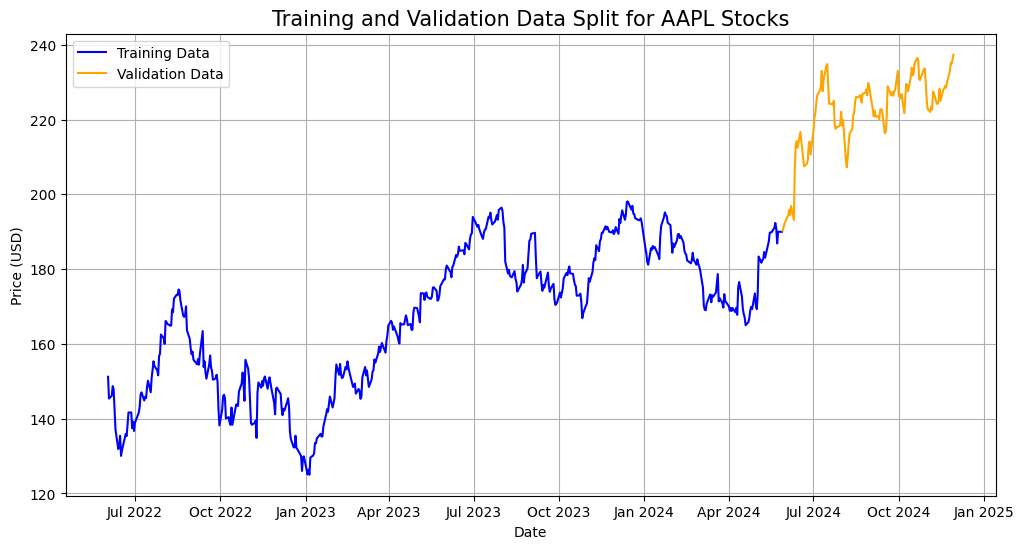

In [ ]:
# Split data into train and test sets
validation_period = data['Date'].max() - DateOffset(months=6)
test = data[data['Date'] >= validation_period].copy()
train = data[data['Date'] < validation_period].copy()

train['Date'] = train['Date'].dt.date
test['Date'] = test['Date'].dt.date

# Print the updated date ranges
print("\nTraining Data Date Range:")
print(f"Start Date: {train['Date'].min()} | End Date: {train['Date'].max()}")

print("\nValidation (Test) Data Date Range:")
print(f"Start Date: {test['Date'].min()} | End Date: {test['Date'].max()}")

# Plot 1: Training and Testing Data Split
plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Close'], label='Training Data', color='blue')
plt.plot(test['Date'], test['Close'], label='Validation Data', color='orange')
date_form = DateFormatter("%b %Y")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'Training and Validation Data Split for {ticker} Stocks', size=15)
plt.legend()
plt.grid(True)
plt.show()

# Use MinMaxScaler to normalize the data

In [ ]:
# Apply the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_close = train['Close'].values.reshape(-1, 1)
test_close = test['Close'].values.reshape(-1, 1)
data_training_array = scaler.fit_transform(train_close)

# Prepare the training dataset for LSTM
def prepare_lstm_data(data_scaled, window_size=30):
    x, y = [], []
    for i in range(window_size, data_scaled.shape[0]):
        x.append(data_scaled[i - window_size:i])
        y.append(data_scaled[i, 0])
    return np.array(x), np.array(y)

x_train, y_train = prepare_lstm_data(data_training_array)

# Combine the last 30 days of the training set with the test set for validation
past_30_days = train['Close'].tail(30).values.reshape(-1, 1)
final_test_data = np.concatenate([past_30_days, test_close], axis=0)

# Scale the combined data
input_data = scaler.transform(final_test_data)

# Prepare x_test and y_test with the combined data
x_test, y_test = prepare_lstm_data(input_data)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (469, 30, 1)
y_train shape: (469,)
x_test shape: (129, 30, 1)
y_test shape: (129,)


# Neural Networks Model (LSTM)

In [ ]:
# Define the LSTM model
model = Sequential()

# First LSTM layer
model.add(
    LSTM(
        units=80,
        activation='tanh',
        return_sequences=True,
        input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))

# Second LSTM layer
model.add(
    LSTM(
        units=70,
        return_sequences=False
    )
)
model.add(Dropout(0.1))

# Dense layers
model.add(Dense(units=10))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 80)              │          26,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 70)                  │          42,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             710 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,241 (270.47 KB)

 Trainable params: 69,241 (270.47 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.007777133391633721),
    loss='mean_squared_error'
)

# Train the model with explicit validation data
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test)
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1520 - val_loss: 0.0867
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - val_loss: 0.0119
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0117
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0156
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - val_loss: 0.0133
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0288
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - val_loss: 0.0112
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0154
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0050
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

# Validation phase: Use the model to predict 6 months of stock prices

In [ ]:
# Predict on the validation (test) set
y_pred = model.predict(x_test)

# Rescale predictions and true values back to original values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


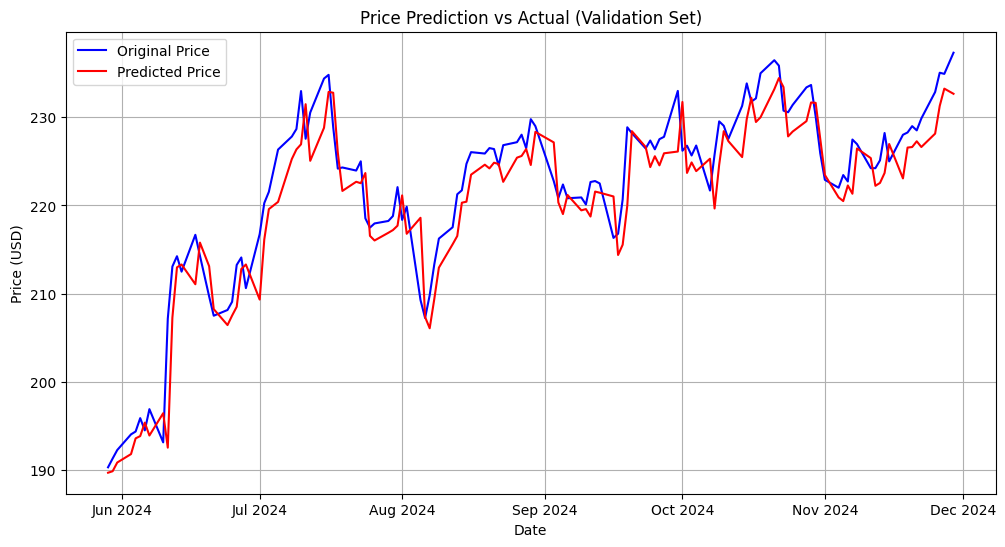

In [ ]:
# Plot the results for the validation set
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, 'b', label="Original Price")
plt.plot(test['Date'], y_pred[-len(test):], 'r', label="Predicted Price")
date_form = DateFormatter("%b %Y")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Price Prediction vs Actual (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

# Measure the performance of the model

Calculation of performance metrics

In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mae_percentage:.2f}%")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 2.88
Mean Absolute Error (MSE): 12.94
Mean Absolute Percentage Error (MAPE): 1.30%
R² Score: 0.88


Scatter plot of predicted vs actual values and Training vs validation loss

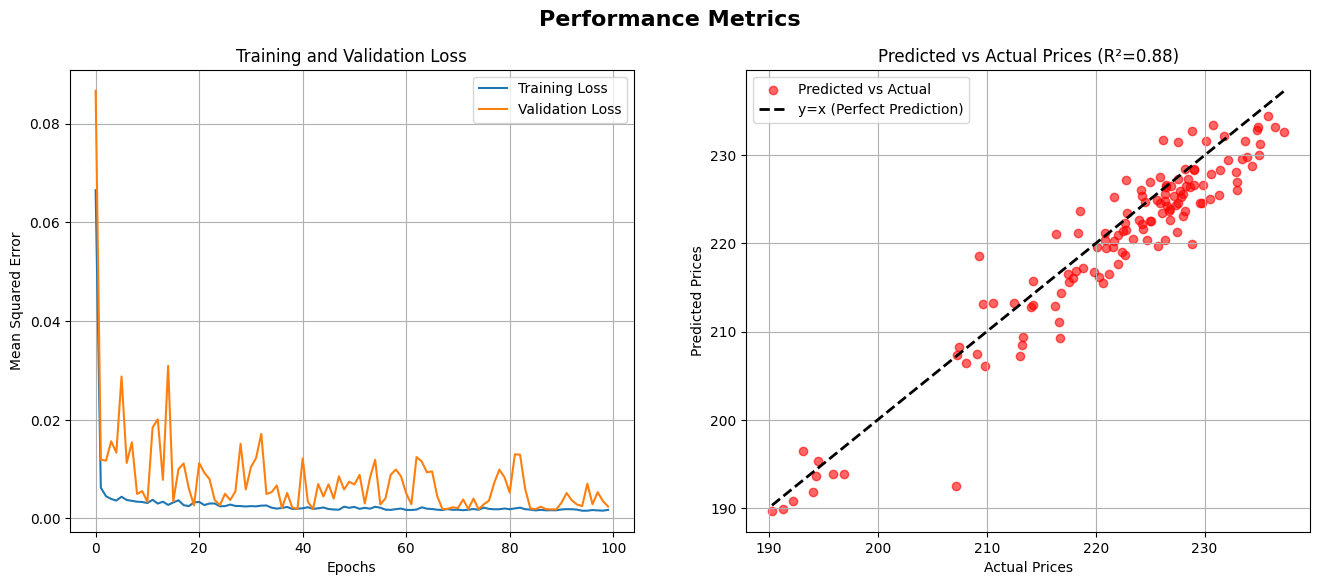

In [ ]:
# Create subplots: Training/Validation Loss and R² scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
fig.suptitle('Performance Metrics', fontsize=16, fontweight='bold')
# Plot 3: Training and Validation Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot 4: R² with y=x line
ax2.scatter(y_test, y_pred, alpha=0.6, color='red', label='Predicted vs Actual')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='y=x (Perfect Prediction)')
ax2.set_xlabel('Actual Prices')
ax2.set_ylabel('Predicted Prices')
ax2.set_title(f'Predicted vs Actual Prices (R²={r2:.2f})')
ax2.legend()
ax2.grid(True)

# Predict the prices of the stock for 5 trading days into the future

In [ ]:
def predict_future(model, last_n_days, scaler, days=5):
    """
    Recursively predict the next 5 trading days using the trained model.
    Excludes weekends (Saturday and Sunday).
    """
    future_predictions = []
    input_sequence = last_n_days.reshape(1, 30, 1)  # Reshape for the model input
    future_dates = []
    current_date = data['Date'].max()  # Start from the last date in the dataset

    while len(future_predictions) < days:
        # Skip weekends
        current_date += timedelta(days=1)
        if current_date.weekday() in [5, 6]:  # Saturday and Sunday
            continue

        # Predict the next day
        next_day_pred = model.predict(input_sequence)[0, 0]
        future_predictions.append(next_day_pred)
        future_dates.append(current_date)

        # Update the input sequence by appending the predicted value and sliding the window
        next_day_scaled = np.append(input_sequence[0, 1:], [[next_day_pred]], axis=0)
        input_sequence = next_day_scaled.reshape(1, 30, 1)

    # Convert predictions back to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).reshape(-1)
    return future_dates, future_predictions

look_back = 30
last_n_days_scaled = scaler.transform(data['Close'].tail(look_back).values.reshape(-1, 1))
future_dates, future_7_days = predict_future(model, last_n_days_scaled, scaler,days= 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


# Plot results

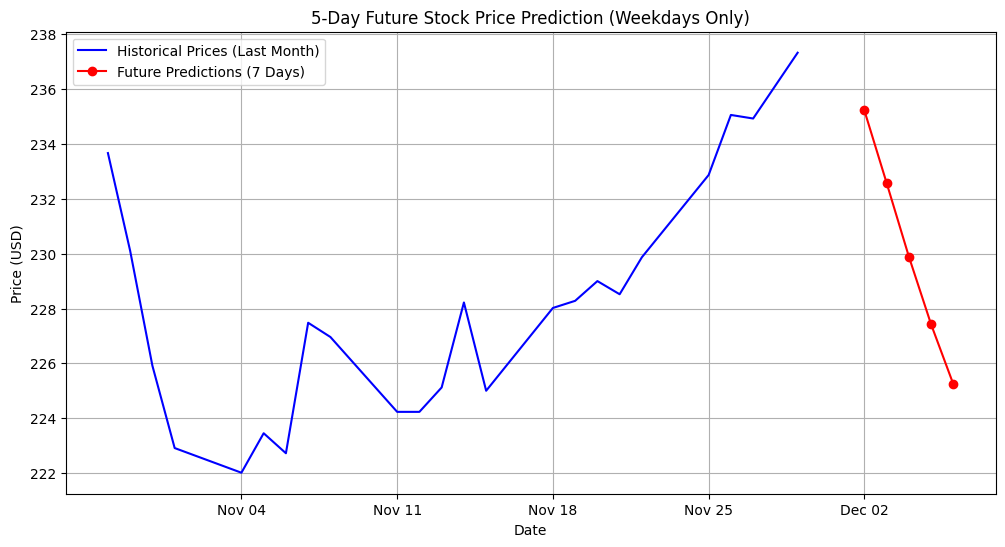

7-Day Predictions (Weekdays Only):
Predicted Price on 2024-12-02: $235.22
Predicted Price on 2024-12-03: $232.58
Predicted Price on 2024-12-04: $229.89
Predicted Price on 2024-12-05: $227.42
Predicted Price on 2024-12-06: $225.24


In [ ]:
# Graph the prediction with 1 month of prior data
plt.figure(figsize=(12, 6))
last_month_data = data[data['Date'] >= data['Date'].max() - pd.DateOffset(months=1)]
plt.plot(last_month_data['Date'], last_month_data['Close'], label="Historical Prices (Last Month)", color='blue')
plt.plot(future_dates, future_7_days, label="Future Predictions (7 Days)", color='red', marker='o')
all_dates = pd.to_datetime(list(last_month_data['Date']) + future_dates)
mondays = [date for date in all_dates if date.weekday() == 0]  # Filter only Mondays
plt.xticks(ticks=mondays, labels=[d.strftime("%b %d") for d in mondays])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('5-Day Future Stock Price Prediction (Weekdays Only)')
plt.legend()
plt.grid(True)
plt.show()

# Print the future predicted prices
print("7-Day Predictions (Weekdays Only):")
for date, price in zip(future_dates, future_7_days):
    print(f"Predicted Price on {date.strftime('%Y-%m-%d')}: ${price:.2f}")